# A Random Forest Model for the Prediction of Purchase Probability of Room
by Jinhao Jiang (leo960809@outlook.com)

### Why Random Forest?
1. RF can easily handle both categorical and numerical features simultaneously;
2. It is fast to train a RF model since we only focus on a subset of features at a time;
3. RF also works for outliners and non-linear data; 
4. RF model enables a low-bias, moderate variance training result;
5. Last but not least, RF is so generalizable and always worths a try.

In [1]:
import pandas as pd
import numpy as np

## A Glimpse of Data

### Training Set

In [2]:
train = pd.read_csv("/Users/leojiang/Desktop/solution/case2_training.csv")
train

,ID,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price,Accept
0,1,4,32,5,1,1,4.526975,0.739994,230.552998,0
1,2,2,87,4,1,1,4.548455,0.862642,348.203425,0
2,3,5,277,5,1,2,4.965732,0.515548,430.462327,0
3,4,3,246,2,1,1,4.752735,0.561547,149.305433,1
4,5,1,155,2,1,2,3.890960,0.817142,165.264184,1
...,...,...,...,...,...,...,...,...,...,...
49995,49996,1,68,6,0,1,3.669174,0.858494,199.187671,1
49996,49997,9,217,1,1,2,4.849890,0.678795,348.927419,0
49997,49998,10,100,3,1,2,4.971527,0.993316,317.187052,1
49998,49999,10,170,3,1,2,4.951120,0.792698,460.453975,0


In [3]:
train.describe()

,ID,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price,Accept
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,25000.500000,5.495460,182.824300,3.99276,0.801840,1.495760,4.509402,0.750261,316.963436,0.27032
std,14433.901067,2.862611,105.653134,2.00837,0.398617,0.693189,0.460287,0.193746,92.644791,0.44413
min,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,3.000000,0.036809,80.000000,0.00000
25%,12500.750000,3.000000,91.000000,2.00000,1.000000,1.000000,4.306552,0.630497,251.637842,0.00000
50%,25000.500000,5.000000,183.000000,4.00000,1.000000,1.000000,4.652005,0.794165,315.334386,0.00000
75%,37500.250000,8.000000,274.000000,6.00000,1.000000,2.000000,4.855238,0.908876,378.920370,1.00000
max,50000.000000,10.000000,365.000000,7.00000,1.000000,4.000000,4.999996,0.999985,726.527643,1.00000


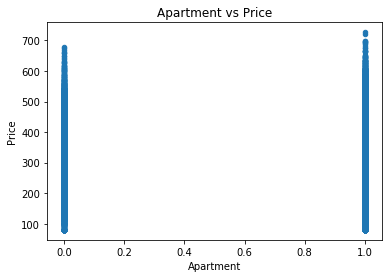

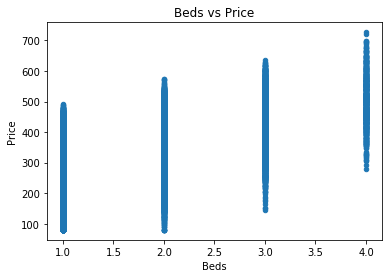

In [5]:
# Based on common sense, apartment/house and the number of beds may affect the price
train.plot(x="Apartment", y="Price", kind="scatter", title="Apartment vs Price")
train.plot(x="Beds", y="Price", kind="scatter", title="Beds vs Price")

### To be noticed:
1. There are 8 categorical features and no numerical feature in the dataset, thus we can encode some features as an one-hot numeric array (e.g. $Region$ and $Weekday$);
2. $Review$ is actually within the range of $[3.0, 5.0)$. Therefore, feature scaling should be applied;
3. There might exist a relationship between different features based on the plots above (e.g. see "$Beds$ vs $Price$"), which implies the use of polynomial features.

## Data Preprocessing

In [6]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures

# One-Hot Encoder added
ohe = OneHotEncoder(categories="auto")
region_code = pd.DataFrame(ohe.fit_transform(train["Region"].values.reshape(-1, 1)).toarray())
weekday_code = pd.DataFrame(ohe.fit_transform(train["Weekday"].values.reshape(-1, 1)).toarray())

# Min-Max Scaler applied
mms = MinMaxScaler(feature_range=(0, 1), copy=False)
review = pd.DataFrame(mms.fit_transform(train["Review"].values.reshape(-1, 1)))

# Polynomial Features added
pf = PolynomialFeatures(interaction_only=True, include_bias=False)
poly_feature = pd.DataFrame(pf.fit_transform(train[["Apartment", "Beds", "Price"]]))

train_df = pd.concat([train.drop(columns=["ID"]), region_code, weekday_code, poly_feature], axis=1, join="outer")
train_df

,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price,Accept,0,...,3,4,5,6,0,1,2,3,4,5
0,4,32,5,1,1,0.763489,0.739994,230.552998,0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,230.552998,1.0,230.552998,230.552998
1,2,87,4,1,1,0.774229,0.862642,348.203425,0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,348.203425,1.0,348.203425,348.203425
2,5,277,5,1,2,0.982868,0.515548,430.462327,0,0.0,...,0.0,1.0,0.0,0.0,1.0,2.0,430.462327,2.0,430.462327,860.924654
3,3,246,2,1,1,0.876369,0.561547,149.305433,1,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,149.305433,1.0,149.305433,149.305433
4,1,155,2,1,2,0.445481,0.817142,165.264184,1,1.0,...,0.0,0.0,0.0,0.0,1.0,2.0,165.264184,2.0,165.264184,330.528368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,68,6,0,1,0.334588,0.858494,199.187671,1,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,199.187671,0.0,0.000000,199.187671
49996,9,217,1,1,2,0.924947,0.678795,348.927419,0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,348.927419,2.0,348.927419,697.854839
49997,10,100,3,1,2,0.985766,0.993316,317.187052,1,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,317.187052,2.0,317.187052,634.374104
49998,10,170,3,1,2,0.975562,0.792698,460.453975,0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,460.453975,2.0,460.453975,920.907949


## Data Spliting

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

### Why Stratified Shuffle Spliting?
1. RF works better on non-overlapped subsets, thus SSS is preferred than K-Fold;
2. SSS preserves the percentage of samples for each class, which fits our dataset with multiple categorical features.

In [8]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

X = np.array(train_df.loc[:, train_df.columns != "Accept"])
y = np.array(train_df.loc[:, train_df.columns == "Accept"])

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

## Hyper-Parameter Optimization

### Among all the hyper-parameters of a Random Forest Classifier, we would optimize:
1. n_estimators: The number of trees in the forest;
2. max_depth: The maximum depth of the tree;
4. max_features: The number of features to consider when looking for the best split.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Why Grid Search?
Grid Search is essentially a brute force method that goes through all possible combinations of hypermeters. We can optimize one parameter at a time to prevent long running time.

In [10]:
# Pick the optimal "n_estimators"
param = {
    "n_estimators": [50, 75, 100, 125, 150]
}

# Pre-define the weights associated with each class (0 or 1 in this case)
weights = {0: 1, 1: (len(y_train)/ np.sum(y_train) - 1)}

gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,
                                                   max_depth=6,
                                                   min_samples_split=50,
                                                   min_samples_leaf=10,
                                                   max_features=6,
                                                   random_state=0,
                                                   class_weight=weights),
                  param_grid=param,
                  scoring="roc_auc", cv=5)

gs.fit(X_train, y_train.ravel())

print("Optimal \"n_estimators\":", gs.best_params_["n_estimators"])
print("Corresponding mean cross-validated score:", "%.5f" % gs.best_score_)

Optimal "n_estimators": 125
Corresponding mean cross-validated score: 0.75917


In [11]:
# Pick the optimal "max_depth"
param = {
    "max_depth": [6, 7, 8, 9, 10]
}

gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=125,
                                                   max_depth=6,
                                                   min_samples_split=50,
                                                   min_samples_leaf=10,
                                                   max_features=6,
                                                   random_state=0,
                                                   class_weight=weights),
                  param_grid=param,
                  scoring="roc_auc", cv=5)

gs.fit(X_train, y_train.ravel())

print("Optimal \"max_depth\":", gs.best_params_["max_depth"])
print("Corresponding mean cross-validated score:", "%.5f" % gs.best_score_)

Optimal "max_depth": 10
Corresponding mean cross-validated score: 0.77618


In [12]:
# Pick the optimal "max_features"
param = {
    "max_features": [6, 7, 8, 9, 10]
}

gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=125,
                                                   max_depth=10,
                                                   min_samples_split=50,
                                                   min_samples_leaf=10,
                                                   max_features=6,
                                                   random_state=0,
                                                   class_weight=weights),
                  param_grid=param,
                  scoring="roc_auc", cv=5)

gs.fit(X_train, y_train.ravel())

print("Optimal \"max_features\":", gs.best_params_["max_features"])
print("Corresponding mean cross-validated score:", "%.5f" % gs.best_score_)

Optimal "max_features": 9
Corresponding mean cross-validated score: 0.77846


## Model Training & Evaluation

### Metrics used:
1. accuracy_score: Accuracy classification score;
2. f1_score: The F1 score, also known as balanced F-score or F-measure;
3. recall_score: To measure the ability of a classifier to find all the positive samples;
4. roc_auc_score: Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score

"""
Based on the estimation above, the optimal hyperparameters are:

n_estimators = 125,
max_depth = 10,
max_features=9.
"""
rfc = RandomForestClassifier(n_estimators=125,
                             max_depth=10,
                             min_samples_split=50,
                             min_samples_leaf=10,
                             max_features=9,
                             random_state=0,
                             class_weight=weights)

rfc.fit(X_train, y_train.ravel())

# Predict the results on testing set
y_pred = rfc.predict(X_test)

# Retrive and print the scores for evaluation
accuracy = accuracy_score(y_test, y_pred, normalize=True)

f1 = f1_score(y_test, y_pred, average="binary")

recall = recall_score(y_test, y_pred, average="binary")

test_prob = rfc.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, test_prob)

print("accuracy_score:", "%.5f" % accuracy)
print("f1_score:", "%.5f" % f1)
print("recall_score:", "%.5f" % recall)
print("auc_roc_socre:", "%.5f" % auc_roc)

accuracy_score: 0.68360
f1_score: 0.57940
recall_score: 0.80617
auc_roc_socre: 0.77851


## Prediction on Testing Dataset

In [14]:
test = pd.read_csv("/Users/leojiang/Desktop/solution/case2_testing.csv")
test

,ID,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price
0,1,1,64,2,1,1,4.923078,0.683932,284.734165
1,2,9,41,7,1,1,4.842211,0.958800,295.051733
2,3,2,275,3,1,3,4.702331,0.500134,385.070370
3,4,8,323,2,1,1,4.388125,0.986082,204.353588
4,5,3,311,4,0,1,3.868994,0.652980,285.488105
...,...,...,...,...,...,...,...,...,...
19995,19996,4,284,5,1,2,3.000000,0.611866,192.158094
19996,19997,10,292,6,1,1,3.305345,0.953897,229.037124
19997,19998,2,295,2,0,1,4.971692,0.902279,287.498583
19998,19999,9,250,6,1,3,3.946708,0.975978,369.307960


In [15]:
test.describe()

,ID,Region,Date,Weekday,Apartment,Beds,Review,Pic Quality,Price
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,5.506950,183.537900,3.981300,0.80000,1.495450,4.510923,0.749830,316.344883
std,5773.647028,2.865687,105.751482,1.992624,0.40001,0.698859,0.458522,0.194596,92.505122
min,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,3.000000,0.022525,80.000000
25%,5000.750000,3.000000,91.000000,2.000000,1.00000,1.000000,4.307864,0.630015,251.544747
50%,10000.500000,6.000000,184.000000,4.000000,1.00000,1.000000,4.653175,0.794744,314.030122
75%,15000.250000,8.000000,276.000000,6.000000,1.00000,2.000000,4.855149,0.909542,377.054871
max,20000.000000,10.000000,365.000000,7.000000,1.00000,4.000000,4.999992,0.999997,684.337728


In [16]:
# One-Hot Encoder added
region_code = pd.DataFrame(ohe.fit_transform(test["Region"].values.reshape(-1, 1)).toarray())
weekday_code = pd.DataFrame(ohe.fit_transform(test["Weekday"].values.reshape(-1, 1)).toarray())

# Min-Max Scaler applied
review = pd.DataFrame(mms.fit_transform(test["Review"].values.reshape(-1, 1)))

# Polynomial Features added
poly_feature = pd.DataFrame(pf.fit_transform(test[["Apartment", "Beds", "Price"]]))

test_df = pd.concat([test.drop(columns=["ID"]), region_code, weekday_code, poly_feature], axis=1, join="outer")

In [17]:
prob = rfc.predict_proba(np.array(test_df))[:, 1]

result = pd.DataFrame(prob, 
                      index=test["ID"], 
                      columns=["Purchase Prob"])
result.to_csv("result.csv")